# Seasonal Forex - Calendar Windows

Implements an **MRCI-style seasonal analysis** for **OANDA spot forex data** to identify recurring profitable calendar windows (buy or sell periods) for a given currency pair. It adapts MRCI’s futures-based process to continuous, non-expiring FX data.

#### 1. **Data Retrieval**

* `get_forex_data_by_pair` should return a pandas DataFrame indexed by date, with columns like `Open, High, Low, Close`.
* The analysis runs on the `Close` column.

#### 2. **Data Preparation**

* `_ensure_dt_index()` ensures the DataFrame index is a `DatetimeIndex`.
* `_available_years()` lists which years are covered.
* `_snap_to_trading_day()` aligns any target date to the next or previous actual trading day in your data (e.g., skip weekends).

#### 3. **Yearly Normalization**

* `compute_year_range_normalized_index()` scales each day’s price within its own year to a 0–100 range:

  [
  r_t = 100 \times \frac{P_t - P_{min,y}}{P_{max,y} - P_{min,y}}
  ]

  This removes long-term drift and makes each year’s pattern comparable.

#### 4. **Seasonal Pattern Curve**

* `build_seasonal_pattern_curve()` averages these 0–100 normalized values by **calendar month-day (MM-DD)** across the last *N* years (default 15).
* The result is the **seasonal index curve**, showing the average relative price position throughout the year.
* Optional smoothing removes noise.

#### 5. **Calendar Window Generation**

* `generate_calendar_grid()` builds all possible entry/exit pairs within chosen months and day ranges (e.g., entry between 5th–25th, exit between 10th–31st).
* Each pair defines a possible trading window (e.g., enter Feb 10 → exit Mar 15).

#### 6. **Year-by-Year Backtest**

* `_compute_window_pnl_for_year()` computes, for each window and each year:

  * entry/exit dates (snapped to valid days),
  * profit in **pips** (long or short),
  * best run-up and worst drawdown during the trade (on closing prices).
* `_pip_factor_for_symbol()` sets pip conversion (100 for JPY pairs, 10 000 otherwise).

#### 7. **Scoring and Filtering**

* `score_windows_on_spot()` aggregates results:

  * win rate (fraction of profitable years),
  * average and median profit,
  * worst loss, drawdown, and run-up.
* Windows must pass reliability filters:

  * ≥ 80 % win rate,
  * ≥ 10 years of data,
  * positive average profit.
* Direction can be fixed (`long`/`short`) or **auto-selected**: the code looks at the seasonal curve slope between entry and exit and chooses the side that follows the pattern.

#### 8. **Ranking and Output**

* Windows are ranked by composite score = (win rate × average profit).
* `run_spot_seasonal_analysis()` orchestrates everything and returns:

  * `seasonal_curve` – the 0–100 pattern for the last N years.
  * `top_windows` – list of best seasonal trade windows with stats.
  * `per_year_results` – detailed yearly entry/exit/P&L data.

#### 9. **Interpretation**

* The **seasonal curve** shows typical strength/weakness periods.
* The **best windows** identify high-reliability date ranges to buy or sell the pair each year.
* The results are settlement-based (daily closes), aligned with MRCI’s methodology.

---

### **Use Case Example**

```python
eurusd_df = load_your_data("EURUSD")  # your DataFrame of OHLC
result = run_spot_seasonal_analysis("EURUSD", df=eurusd_df)

for w in result["top_windows"][:5]:
    print(w)
```

You’ll get calendar date windows like:

```
Entry 02-15 → Exit 03-10, Win Rate = 86 %, Avg Profit = +55 pips
Entry 07-05 → Exit 07-25, Win Rate = 81 %, Avg Profit = +42 pips
```

---

In short, this code **discovers statistically consistent seasonal trade windows** for any OANDA forex pair, replicating the **MRCI 15-year seasonal pattern and reliability test** without using futures data.


In [ ]:
from temp_strategy_runners.temp.get_forex_data import get_forex_data_by_pair

eurusd_df = get_forex_data_by_pair(symbol="EURUSD", granularity="D")

Loading cached forex data from: /home/matrillo/apps/jupyter-notebooks/trading_notebooks/cache/forex_EURUSD_D_None_None.pkl
Loaded cached data for EURUSD: 3935 rows


`run_spot_seasonal_analysis` parameters:

* `symbol`: sets pip conversion (e.g., JPY pairs use 0.01 → factor 100). Needed to score P&L in pips correctly.
* `months`: limits which parts of the year to scan. Reduces noise and runtime if you only care about certain seasons.
* `entry_day_range`: bounds candidate entry dates within each chosen month. Controls where windows can start.
* `exit_day_range`: bounds candidate exit dates. Controls where windows can end.
* `min_len_days`: drops windows too short to be tradable or statistically stable.
* `max_len_days`: drops windows so long they blur seasonality or inflate exposure.
* `direction`: fixes side (`long`/`short`) or lets the code choose based on seasonal slope (`auto`). Prevents scoring the wrong side.

You can keep broad defaults, but these knobs are how you target the calendar, control combinatorics, and get valid, comparable pips.


In [2]:
from temp_strategy_runners.temp.seasonal import run_spot_seasonal_analysis

res = run_spot_seasonal_analysis(
    "EURUSD",
    df=eurusd_df,
    lookback_years=15,
    months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    entry_day_range=(8, 22),
    exit_day_range=(12, 31),
    min_len_days=5,
    max_len_days=35,
    direction="auto",
)

Excluding incomplete last year: 2025
Excluding incomplete last year: 2025


In [3]:
print("Best windows:")
for w in res["top_windows"][:10]:
    print(w)

Best windows:
WindowStats(entry_mmdd='10-21', exit_mmdd='11-21', num_trades=14, win_rate=np.float64(0.8571428571428571), avg_profit_pips=167.79999999999995, median_profit_pips=213.39999999999804, worst_loss_pips=-383.09999999999957, best_runup_pips=697.6000000000005, worst_drawdown_pips=-537.1000000000004, direction='short')
WindowStats(entry_mmdd='10-21', exit_mmdd='11-20', num_trades=14, win_rate=np.float64(0.8571428571428571), avg_profit_pips=149.72142857142853, median_profit_pips=207.34999999999948, worst_loss_pips=-466.60000000000036, best_runup_pips=697.6000000000005, worst_drawdown_pips=-537.1000000000004, direction='short')
WindowStats(entry_mmdd='10-21', exit_mmdd='11-12', num_trades=14, win_rate=np.float64(0.8571428571428571), avg_profit_pips=139.2142857142858, median_profit_pips=159.6999999999993, worst_loss_pips=-495.5999999999994, best_runup_pips=614.6000000000007, worst_drawdown_pips=-495.5999999999994, direction='short')
WindowStats(entry_mmdd='09-15', exit_mmdd='09-30',

Interpretation:

Each line is a **historical seasonal trade window**—a date range where the same short trade repeatedly made money over the past 14 years for EURUSD.

Key fields:

| Field                     | Meaning                                                                                |
| ------------------------- | -------------------------------------------------------------------------------------- |
| `entry_mmdd`, `exit_mmdd` | Calendar dates to enter and exit each year (e.g. short EURUSD around Oct 21 → Nov 21). |
| `num_trades`              | Number of years tested (here 14).                                                      |
| `win_rate`                | Fraction of years profitable (0.857 ≈ 12 of 14 years).                                 |
| `avg_profit_pips`         | Average net gain per trade window in pips across those years.                          |
| `median_profit_pips`      | Median gain—robust measure of central tendency.                                        |
| `worst_loss_pips`         | Largest single-year loss in that window.                                               |
| `best_runup_pips`         | Best unrealized profit (peak-to-entry) during any year—path high.                      |
| `worst_drawdown_pips`     | Worst unrealized drawdown (valley-to-entry) during any year—path low.                  |
| `direction`               | Trade side chosen (‘short’ means EURUSD tends to fall in that window).                 |

Summary for your output:

* **Seasonal bias:** short EURUSD around late October → late November.
  Multiple adjacent windows (10-20 → 11-12 etc.) confirm the same seasonal downswing.
* **Reliability:** ~86 % of years profitable.
* **Magnitude:** +130 – 170 pips average gain, −380 to −570 pips worst single-year loss.
* **Risk profile:** typical reward ≈ 150 pips vs. occasional 400–500 pip loss, so 3–4 : 1 hit rate compensates for risk.
* **Practical interpretation:** you would open a **short** EURUSD position near **Oct 21** and close it near **Nov 21**, each year, expecting a recurring seasonal decline.

In short:

> The EURUSD has historically tended to weaken from mid- to late October through mid- to late November. These results quantify how consistent and profitable that pattern has been over the past ≈ 15 years.


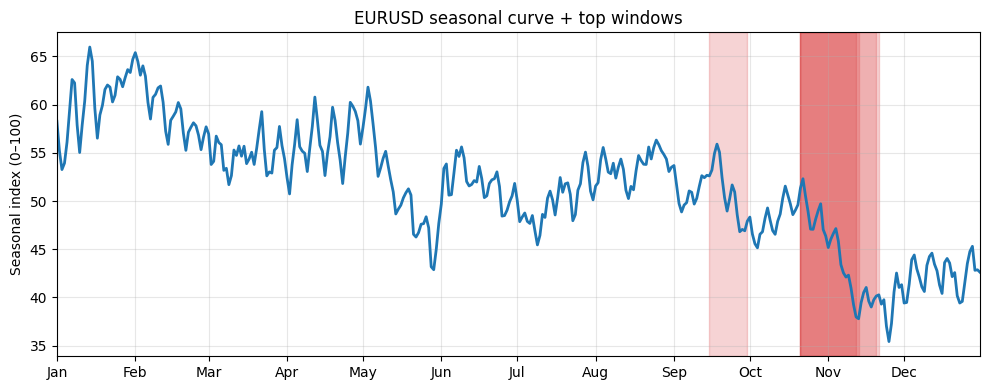

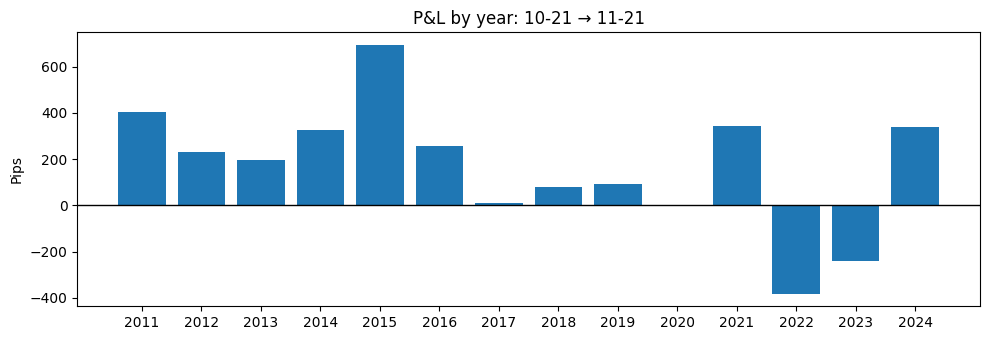

In [4]:
from temp_strategy_runners.temp.seasonal import (
    plot_seasonal_curve_with_windows,
    plot_per_year_pnl,
)

# 1) Shade your top windows over the seasonal curve
plot_seasonal_curve_with_windows(
    res["seasonal_curve"],
    res["top_windows"][:5],
    title=f"{res['symbol']} seasonal curve + top windows",
)

# 2) Bar chart for one specific window
w = res["top_windows"][0]
plot_per_year_pnl(res["per_year_results"], w.entry_mmdd, w.exit_mmdd)

# Seasonal Forex - Plotting the Seasonal Closes of the 5-Year, 10-Year, and 15-Year Periods

Excluding incomplete last year: 2025
Excluding incomplete last year: 2025
Excluding incomplete last year: 2025


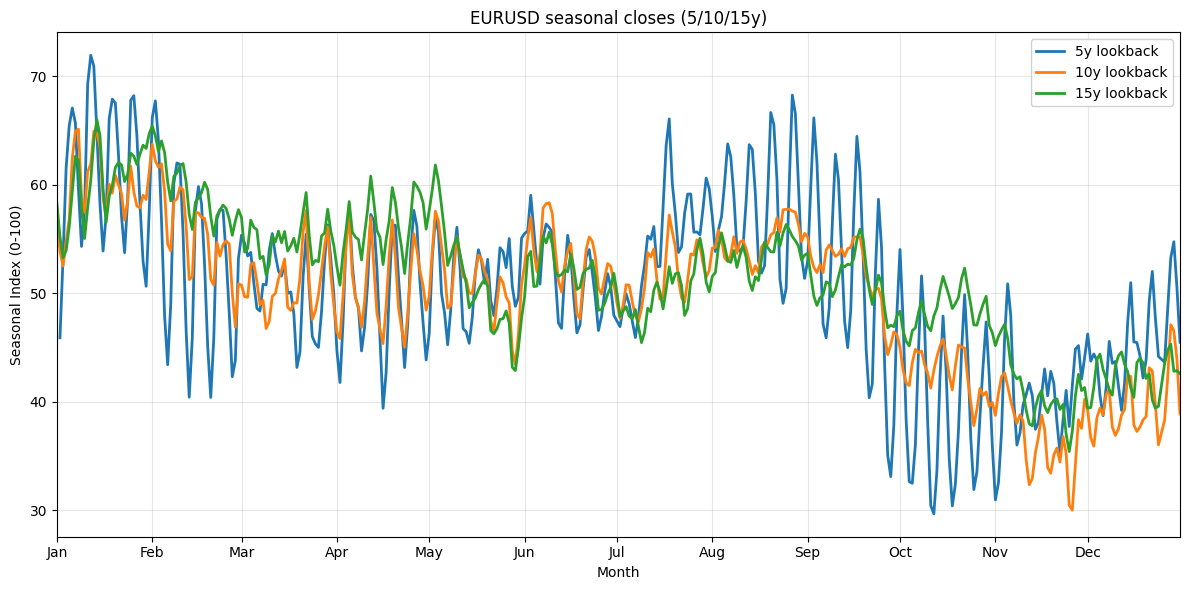

In [5]:
from temp_strategy_runners.temp.seasonal import (
    plot_seasonal_stacks_by_lookback,
)

plot_seasonal_stacks_by_lookback(
    eurusd_df,
    lookbacks=(5, 10, 15),
    title=f"{res['symbol']} seasonal closes (5/10/15y)",
)

In [ ]:
raise

# Developing a Filter

Use the seasonal objects to build a **boolean mask** you AND with your system’s entries. Four practical “don’t trade if …” conditions:

1. **Window blacklist (high-reliability cluster)**

* Don’t take trades **against** the seasonal side during top windows with win_rate ≥ τ.
* Example: if a `short` window Oct-21→Nov-21 has win_rate 0.86, block **longs** on those dates.

2. **Seasonal slope filter**

* Compute Δ seasonal_index over k days.
* Don’t trade **against** the sign of the slope when |Δ| ≥ s_th.

3. **Percentile band filter**

* Don’t fade extremes: when seasonal_index in top q% block **long mean-reversion** exits/entries; when bottom q% block **short mean-reversion**.

4. **Agreement filter (robustness)**

* Build 5y/10y/15y curves.
* Don’t trade if their slopes disagree in sign; trade only when ≥2 agree and you’re aligned.


Typical “don’t trade if …” choices (pick any subset):

* Don’t take **longs** when seasonal slope is **down** and strong (Δ index ≤ −1 over 5 days).
* Don’t take **shorts** when slope is **up** and strong.
* Don’t trade **against** the seasonal side inside **top windows** with win_rate ≥ 80%.
* Don’t initiate when seasonal_index is in **extremes** (top/bottom 15%) if your system is mean-reversion the other way.
* Don’t trade unless **≥2 of 5y/10y/15y** slopes agree with your side.

These filters are deterministic, fast, and align with the MRCI spirit while preserving your system’s core logic.

In [ ]:
from temp_strategy_runners.temp.seasonal_filters import build_seasonal_filter

# precomputed results
res = run_spot_seasonal_analysis("EURUSD", df=eurusd_df, lookback_years=15)
flt = build_seasonal_filter(eurusd_df, res["seasonal_curve"], res["top_windows"],
                            win_rate_thr=0.80, slope_k=5, slope_mag_thr=1.0, pct_q=0.15)

# Example: gate entries
signals = my_system_signals.copy()  # columns: long_entry, short_entry (bool)
signals["long_entry"]  &= flt["allow_long"]
signals["short_entry"] &= flt["allow_short"]